## Model 3
### Data

In [ ]:
import os

dir_path = 'C:/python'
base_dir = (dir_path + '/dogs-vs-cats_small')
train_dir = os.path.join(base_dir, 'train')
dev_dir = os.path.join(base_dir,'dev')
test_dir = os.path.join(base_dir, 'test')

### 4.1 Small dataset with pretrained network

I am going to use pretrained network which is the most powerful feature of deep convolutional networks. 

By using pretrained network, trained by other image dataset, we can handle image tasks with small dataset.

One of reason that make this possible is its feature, sharing of parameteres. Learning large image dataset, networks learn

how to find out its minor feature of image, like  edge, corner or small pattern. 

To do the tasks with small dataset, we pretrain networks with ImageNet dataset for VGG networks, which has very simple structure.

##### Feature extraction and fine tuning

There are two ways to use pretrained networks, featrue extraction and fine tuning. We can simply distinguish 

them by using conv layers for every training or just using conv layers to get new input.

Firstly, let's use feature extraction.

In [2]:
from keras.applications import VGG16

Using TensorFlow backend.


In [3]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

##### Tips for using pretrained networks

- First of all, we usually use the conv layers part of preatrained networks. Because only conv layers, not fully connected layers, can share 

weights and detect feature of image. 

- And, if the dataset is quite different between for pretrain and new dataset, it is reasonable to only use first part of conv layers for feature extraction.

##### In code,

- If we don't define 'input shape', it would handle any shape of input data.

- include_top determine whether or not to include fully connected layers of VGG16. We will add our own fully connected layers.

### 4.2 Feature Extraction

In feature extraction tasks, there are two ways to extract feature, 

##### Method 1 (Quick)
1. Feed new data through conv layers for m (number of smaples) times
- Save m output as numpy array
- Flatten output
- Use output as new input for normal and train for few epochs

It is computationally cheap because we feed new image data into conv layers only one time. Computation in conv layers is the most

expensive part of neural networks. But we can't use data augmentation.

##### Method 2 (Slow, not proper for CPU)

1. Extend  fully connected layers on the conv layers
2. Treat it as a one model
3. Feed new data through conv layers

We can use data augmentation but it is computationally expensive. Main difference between these two models is that whether we can

use data augmentation to avoid high variance problem.

#### 4.2.1 Method 1

##### Data preprocessing and
##### extract feature by feeding data through conv_base

In [11]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255) # We only rescale input, not augmentation.
batch_size = 30

def extract_features(directory, sample_count):
    
    # Initialize features and labels to extract
    
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # Shape of output from conv
    labels = np.zeros(shape=(sample_count))
    
    generator = datagen.flow_from_directory(directory, 
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # Break after getting all samples feature. We have to make sure to define break. Generator creates data infinitely.
            
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
dev_features, dev_labels = extract_features(dev_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##### Flatten

(m, 4, 4, 512) to (m, 4 * 4 * 512)

In [13]:
train_features = np.reshape(train_features,(2000, 4 * 4* 512))
dev_features = np.reshape(dev_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

##### Fully connected layers

In [15]:
from keras import models
from keras import layers
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import optimizers

model = models.Sequential()

model.add(Dense(256, input_dim=4 * 4 * 512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

##### Compile

In [18]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                 loss='binary_crossentropy',
                 metrics=['acc'])

##### Train

In [19]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(dev_features, dev_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.6194 - acc: 0.6555 - val_loss: 0.4350 - val_acc: 0.8460
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4339 - acc: 0.7980 - val_loss: 0.3590 - val_acc: 0.8710
Epoch 3/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3585 - acc: 0.8405 - val_loss: 0.3217 - val_acc: 0.8830
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3221 - acc: 0.8725 - val_loss: 0.2977 - val_acc: 0.8840
Epoch 5/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2933 - acc: 0.8740 - val_loss: 0.2823 - val_acc: 0.8890
Epoch 6/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2739 - acc: 0.8910 - val_loss: 0.2696 - val_acc: 0.8930
Epoch 7/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2528 - acc: 0.9015 - val_loss: 0.2635 - val_acc: 0.8940
Epoch 8/30
200

##### Evaluate with graph

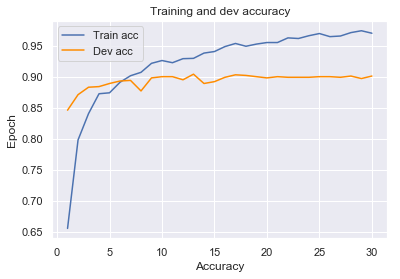

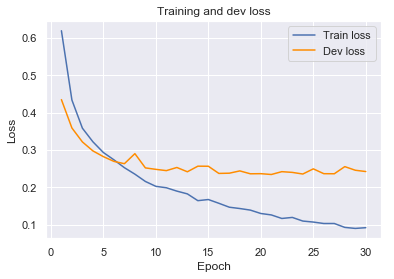

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")

acc = history.history['acc']
dev_acc = history.history['val_acc']
loss = history.history['loss']
dev_loss = history.history['val_loss']

epochs = (range(1, len(acc) + 1))

plt.plot(epochs, acc, 'b', label='Train acc')
plt.plot(epochs, dev_acc, 'darkorange', label='Dev acc')
plt.xlabel('Accuracy')
plt.ylabel('Epoch')
plt.title('Training and dev accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Train loss')
plt.plot(epochs, dev_loss, 'darkorange', label='Dev loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and dev loss")
plt.legend()

plt.show()

It shows about 90% accuracy. But We can see that model becomes overfitting after few epochs. It is because we couldn't use

data augmentation which is powerful when we have small dataset.